In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.preprocessing import StandardScaler


# Functions

In [2]:
def plot_wordcloud_and_keywords(text_series, title, n_words=20, max_words=200):
    """
    Generate wordcloud and top keywords visualization for a text series.
    
    Parameters:
    - text_series: pandas Series of text data
    - title: title for the visualizations
    - n_words: number of top keywords to display (default 20)
    - max_words: max words in wordcloud (default 200)
    """
    # Generate wordcloud
    text = " ".join(text_series)
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        max_words=max_words
    ).generate(text)
    
    plt.figure(figsize=(14, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud — {title}")
    plt.show()
    
    # Get and plot top keywords
    def get_top_words(text_series, n=20):
        words = " ".join(text_series).lower().split()
        words = [w for w in words if w.isalpha() and w not in STOPWORDS]
        return Counter(words).most_common(n)
    
    top_words = get_top_words(text_series, n=n_words)
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(12, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.title(f"Top Keywords — {title}")
    plt.tight_layout()
    plt.show()



def plot_crosstab_heatmap(
    df,col_x,col_y,
    normalize=None,
    max_categories=15,
    figsize=(8,5),
    label_max_len=10
):
    top_x = df[col_x].value_counts().nlargest(max_categories).index
    top_y = df[col_y].value_counts().nlargest(max_categories).index
    subset = df[df[col_x].isin(top_x) & df[col_y].isin(top_y)]

    if normalize is None:
        ct = pd.crosstab(subset[col_x],subset[col_y]); fmt='d'
    else:
        ct = pd.crosstab(subset[col_x],subset[col_y],normalize=normalize); fmt='.2f'

    plt.figure(figsize=figsize)
    ax = sns.heatmap(ct,annot=True,fmt=fmt,cmap='Blues',linewidths=0.5)

    ax.set_xticklabels(
        [t.get_text()[:label_max_len]+'…' if len(t.get_text())>label_max_len else t.get_text()
         for t in ax.get_xticklabels()],
        rotation=45,ha='right'
    )
    ax.set_yticklabels(
    [t.get_text()[:label_max_len]+'…' if len(t.get_text())>label_max_len else t.get_text()
     for t in ax.get_yticklabels()],
    rotation=0,ha='right'
)

    plt.title(f"{col_x} vs {col_y}")
    plt.xlabel(col_y); plt.ylabel(col_x)
    plt.tight_layout(); plt.show()

def plot_text_length_comparison(df, columns, stat='median', title_prefix=''):
    """
    Plot comparison of text lengths between real and fraudulent jobs.
    
    Parameters:
    - df: DataFrame with 'fraudulent' column and text length columns
    - columns: list of column names to plot
    - stat: 'mean' or 'median' (default 'median')
    - title_prefix: custom prefix for title
    """
    # Calculate statistic
    text_lengths = df.groupby('fraudulent')[columns].agg(stat)
    
    print(f"{stat.capitalize()} text lengths:")
    print(text_lengths)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(text_lengths.columns))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, text_lengths.loc[0], width, label='Real Jobs', color='#2ecc71')
    bars2 = ax.bar(x + width/2, text_lengths.loc[1], width, label='Fraudulent Jobs', color='#e74c3c')
    
    ax.set_xlabel('Text Field', fontsize=12)
    ax.set_ylabel(f'{stat.capitalize()} Length (characters)', fontsize=12)
    ax.set_title(f'{title_prefix}{stat.capitalize()} Text Length: Real vs Fraudulent Job Postings', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(['Description', 'Requirements', 'Company Profile'])
    ax.legend()
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()



# Initial Look At Data

### Dataset Overview

This dataset contains job postings with a mix of textual, categorical, and binary attributes.  
The goal of the exploratory data analysis (EDA) is to understand data structure, identify meaningful patterns, and decide which features are appropriate for downstream unsupervised learning.

At this stage, no modeling assumptions are made and no feature transformations are finalized.


In [3]:

jobs = pd.read_csv("fake_job_postings.csv")
jobs.drop(columns=['job_id'], inplace=True)
print(f'Shape of the data frame: {jobs.shape} ')
print("\n=== INFO ===")
print(jobs.info())
print("\n=== HEAD ===")
print(jobs.head())
jobs.describe()

Shape of the data frame: (17880, 17) 

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  f

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


# Sort Features by type

In [4]:
label = ['fraudulent']
object = jobs.select_dtypes(include=['object']).columns.tolist()
text_cols = ['description', 'requirements', 'company_profile', 'benefits']
categorical=list(set(object) - set(text_cols))
numeric = jobs.select_dtypes(include=['int64','float64']).columns.tolist()
numeric = [c for c in numeric if c not in label]

print("Categorical columns:", categorical)
print("\nNumeric columns:", numeric)
print("\nText columns:", text_cols)

Categorical columns: ['required_experience', 'employment_type', 'department', 'salary_range', 'function', 'location', 'required_education', 'industry', 'title']

Numeric columns: ['telecommuting', 'has_company_logo', 'has_questions']

Text columns: ['description', 'requirements', 'company_profile', 'benefits']


# Data Cleaning



### Missing Values Analysis


- Missing values were examined across all feature groups. Categorical and text features exhibit meaningful levels of missingness. Given the context of job postings, missingness is treated as informative rather than an error. For example no required education might just mean there isn't an education requirement. As a result, missing categorical values are preserved explicitly

- Numeric binary indicators are largely complete. If they are not then they will be set to 0 then adding and text-derived features naturally encode absence as zero-valued measures. 


In [5]:
missing = jobs.isna().mean().sort_values(ascending=False)
missing = missing.to_frame('missing_pct')
print(missing.assign(missing_pct=lambda x:(x.missing_pct*100).round(2)))
print(jobs[numeric].isna().sum())

                     missing_pct
salary_range               83.96
department                 64.58
required_education         45.33
benefits                   40.34
required_experience        39.43
function                   36.10
industry                   27.42
employment_type            19.41
company_profile            18.50
requirements               15.08
location                    1.94
description                 0.01
title                       0.00
telecommuting               0.00
has_questions               0.00
has_company_logo            0.00
fraudulent                  0.00
telecommuting       0
has_company_logo    0
has_questions       0
dtype: int64


## Duplicate Row Handling

Exact duplicate rows were identified within the dataset. Because these duplicates represent identical job postings rather than independent observations, they do not contribute additional informational value and can bias distance-based unsupervised learning methods. As a result, exact duplicates are removed

In [6]:
before = len(jobs)
jobs = jobs.drop_duplicates()
after = len(jobs)
dropped = before - after
print(f'Rows before: {before} \n Rows after: {after} \n Duplicates removed: {dropped}')

Rows before: 17880 
 Rows after: 17599 
 Duplicates removed: 281


### Visualizing description text 

In [7]:
jobs['description'] = jobs['description'].fillna("")

real_jobs = jobs[jobs['fraudulent'] == 0]['description']
fake_jobs = jobs[jobs['fraudulent'] == 1]['description']

Visualizing Real Job Descriptions


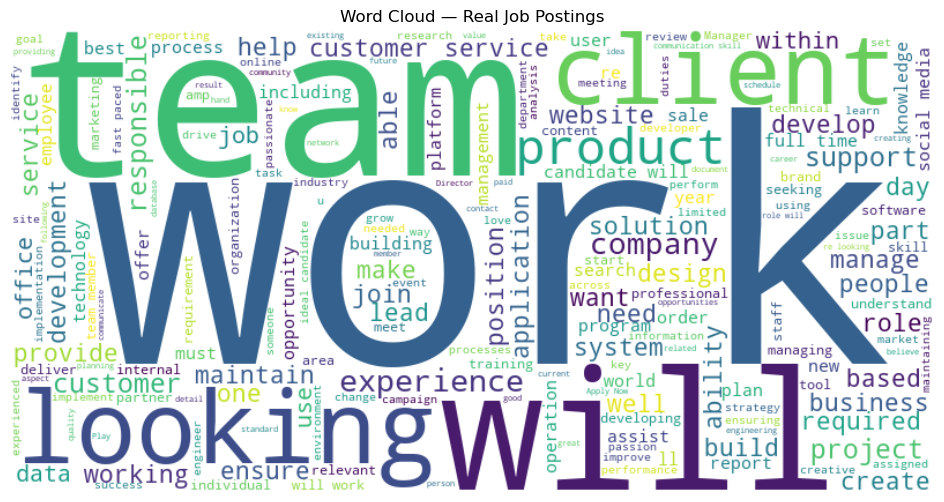

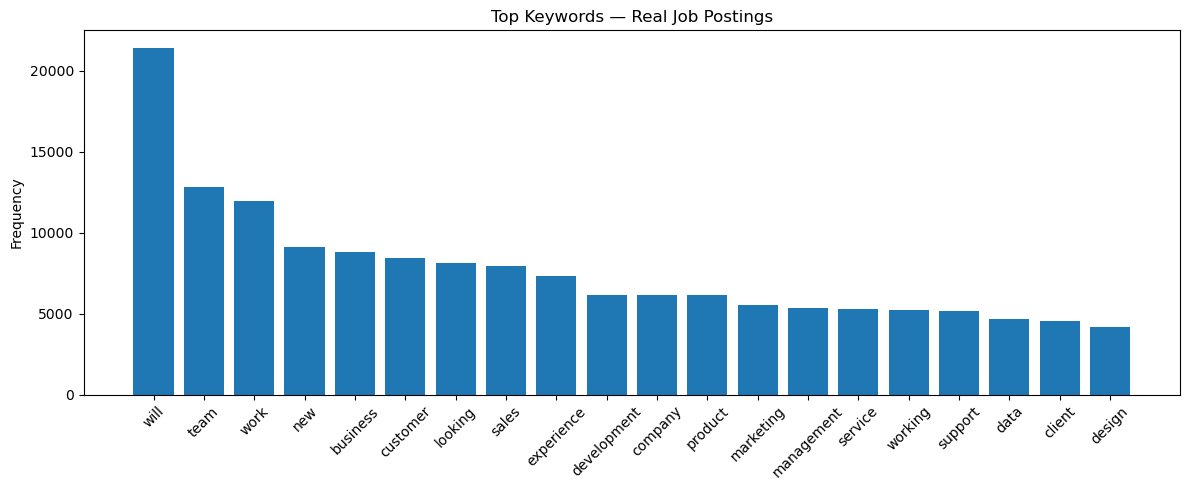

In [8]:
print("Visualizing Real Job Descriptions")
plot_wordcloud_and_keywords(real_jobs, "Real Job Postings")


Visualizing Fradulent Job Descriptions


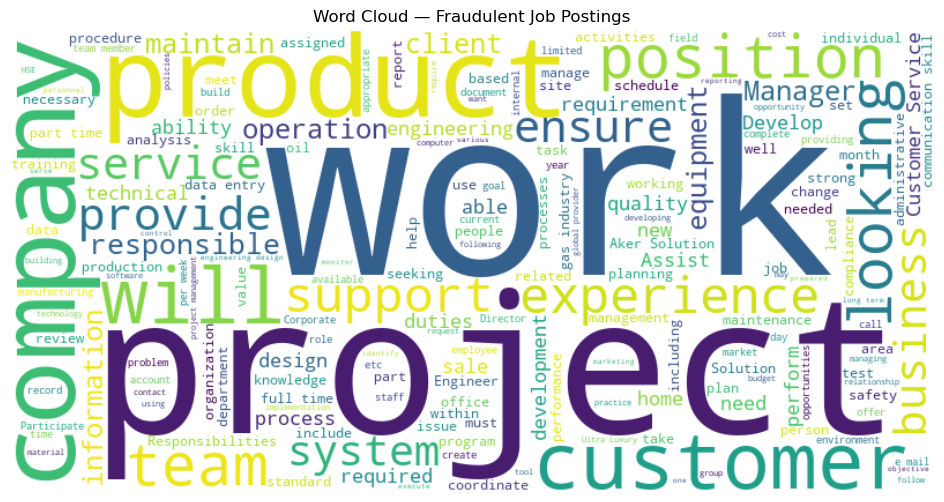

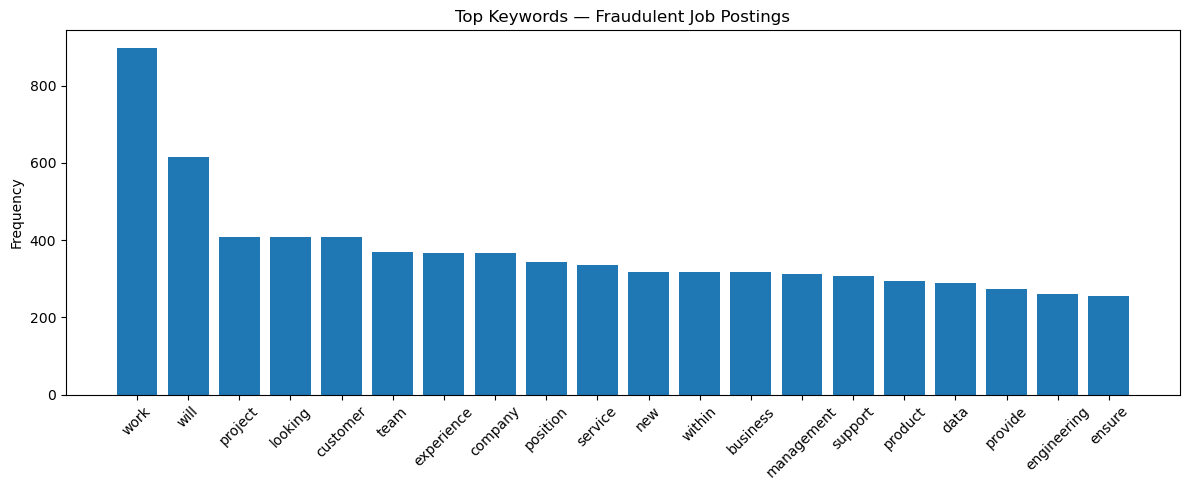

In [9]:
print("Visualizing Fradulent Job Descriptions")
plot_wordcloud_and_keywords(fake_jobs, "Fraudulent Job Postings")

# Feature Engineering

### Grouped Country and Industry Features

To reduce categorical sparsity, country and industry variables were grouped by retaining the most frequent categories and consolidating rare values into an "Other" group. Missing values were explicitly labeled as a separate category.

The resulting distributions are consistent with expectations, with postings concentrated in a small number of dominant countries and industries and a substantial long tail of niche categories.

In [10]:
# Text lengths
jobs['description_len'] = jobs['description'].fillna('').str.len()
jobs['requirements_len'] = jobs['requirements'].fillna('').str.len()
jobs['company_profile_len'] = jobs['company_profile'].fillna('').str.len()

# Unique word counts
jobs['description_uwc'] = jobs['description'].fillna('').apply(lambda x: len(set(x.lower().split())))
jobs['requirements_uwc'] = jobs['requirements'].fillna('').apply(lambda x: len(set(x.lower().split())))
jobs['company_profile_uwc'] = jobs['company_profile'].fillna('').apply(lambda x: len(set(x.lower().split())))

# Look at Fradulent Column


Fraudulent job postings distribution:
fraudulent
0    95.136087
1     4.863913
Name: proportion, dtype: float64


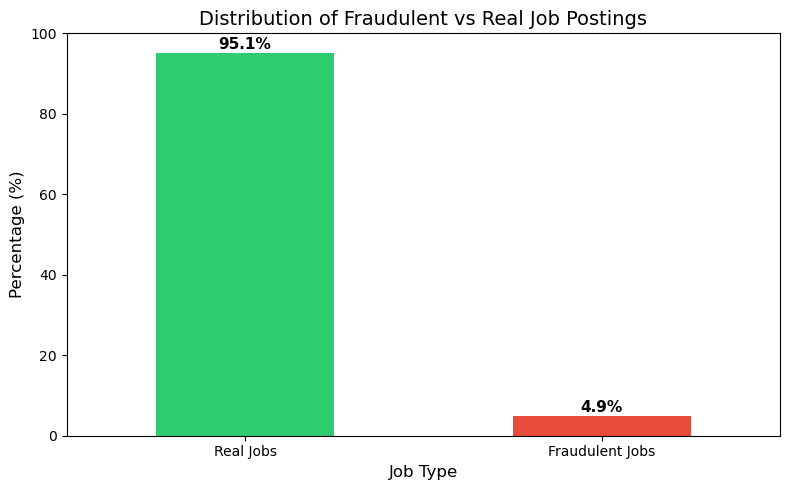

In [11]:

# Fraudulent job postings distribution
fraud_dist = jobs["fraudulent"].value_counts(normalize=True) * 100

print("Fraudulent job postings distribution:")
print(fraud_dist)

# Create bar plot
plt.figure(figsize=(8, 5))
fraud_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=plt.gca())
plt.xlabel('Job Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Distribution of Fraudulent vs Real Job Postings', fontsize=14)
plt.xticks([0, 1], ['Real Jobs', 'Fraudulent Jobs'], rotation=0)
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(fraud_dist):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Look at features by data type


# Text Analysis

### **Text lengths**    
Comparing text lengths between real and fraudulent postings shows that legitimate jobs tend to contain more detailed descriptions, requirements, and company profiles. Fraudulent postings are, on average, shorter across all major text fields.

This pattern suggests that posting verbosity may serve as a weak but informative indicator of posting authenticity. These findings motivate the inclusion of text-length features in later modeling stages.


In [12]:
jobs[["description_len","requirements_len","company_profile_len"]].describe()

,description_len,requirements_len,company_profile_len
count,17599.000000,17599.000000,17599.000000
mean,1217.205125,591.365646,619.567305
std,895.310918,614.195428,567.937902
min,0.000000,0.000000,0.000000
25%,604.000000,148.500000,134.000000
50%,1017.000000,468.000000,560.000000
75%,1585.500000,822.000000,879.000000
max,14907.000000,10864.000000,6178.000000


Median text lengths:
            description_len  requirements_len  company_profile_len
fraudulent                                                        
0                    1026.0             477.0                583.0
1                     844.5             249.0                  0.0


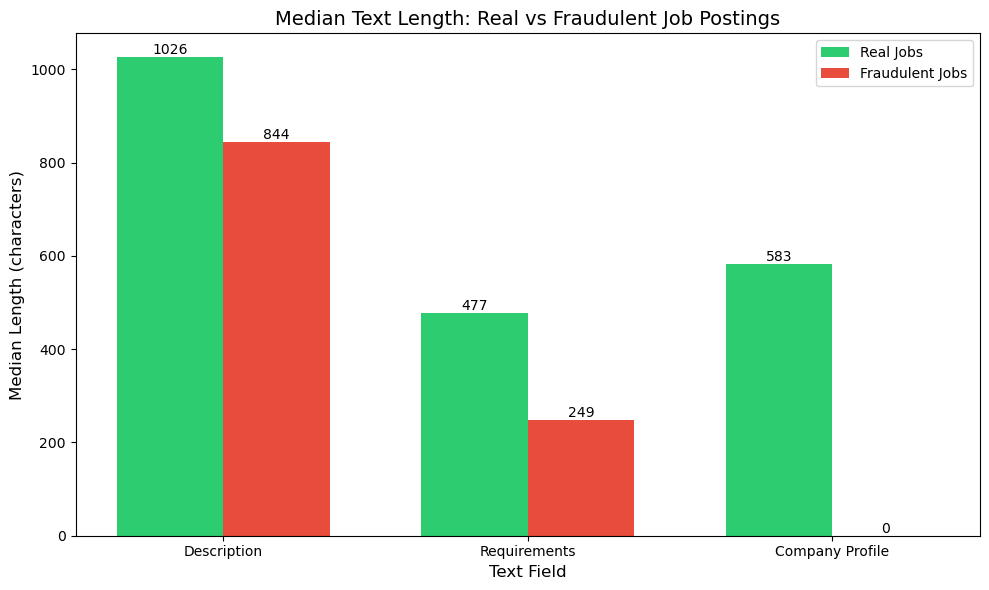

Mean text lengths:
            description_len  requirements_len  company_profile_len
fraudulent                                                        
0               1220.228036        598.688706           639.381592
1               1158.078271        448.129673           232.008178


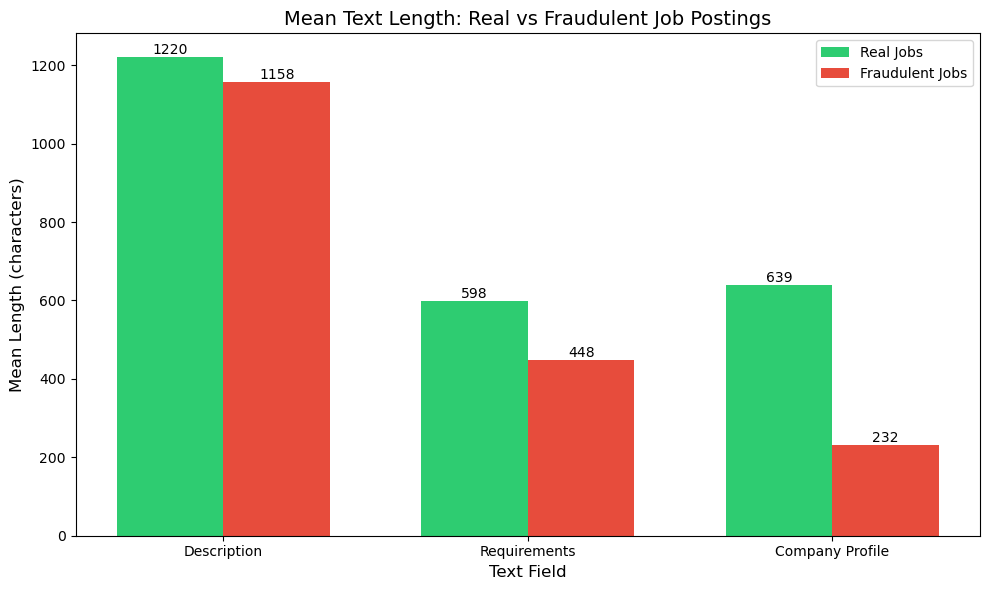

In [13]:
# Check text length for real vs Fraud for the median
plot_text_length_comparison(jobs, ['description_len','requirements_len','company_profile_len'], stat='median')

# Check text length for real vs Fraud for the mean
plot_text_length_comparison(jobs, ['description_len','requirements_len','company_profile_len'], stat='mean')


Percentage of missing fields by fraud status:
            description  requirements  company_profile
fraudulent                                            
0                   0.0     14.919668        16.138088
1                   0.0     17.640187        67.757009


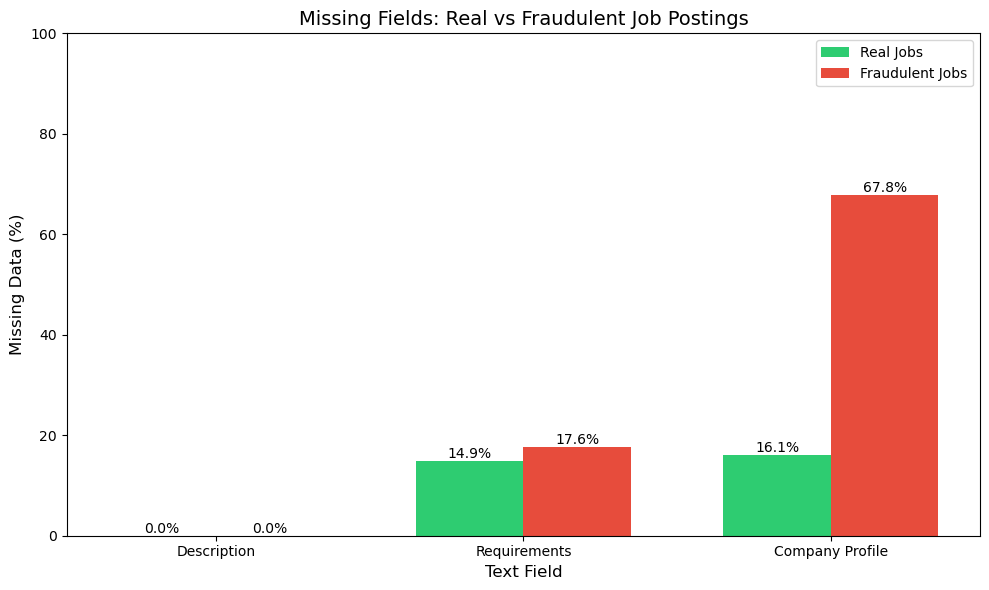

In [14]:
# Check to see if fraudulent jobs are more likely to leave fields blank
missing_by_fraud = (jobs[['description','requirements','company_profile']]
                    .isna()
                    .groupby(jobs['fraudulent'])
                    .mean() * 100)

print("Percentage of missing fields by fraud status:")
print(missing_by_fraud)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(missing_by_fraud.columns))
width = 0.35

bars1 = ax.bar(x - width/2, missing_by_fraud.loc[0], width, label='Real Jobs', color='#2ecc71')
bars2 = ax.bar(x + width/2, missing_by_fraud.loc[1], width, label='Fraudulent Jobs', color='#e74c3c')

ax.set_xlabel('Text Field', fontsize=12)
ax.set_ylabel('Missing Data (%)', fontsize=12)
ax.set_title('Missing Fields: Real vs Fraudulent Job Postings', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Description', 'Requirements', 'Company Profile'])
ax.set_ylim(0, 100)
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# **Numeric and Binary Feature Analysis**

Binary variables in the dataset are highly imbalanced, with most postings containing a company logo and relatively few offering telecommuting options. This imbalance is expected given typical job market practices.

Text-length features exhibit strong right skew, with medians substantially lower than maximum values. While extreme cases exist (very long descriptions or requirements), these appear to be legitimate long-tail observations rather than errors. As a result, these features are retained, with the understanding that scaling or transformation will be required during modeling.

#### **Textual diversity**
To assess textual diversity, the number of unique words per description was computed. This measure approximates lexical richness and highlights repetitive or templated language usage.

Fraudulent job postings exhibit lower vocabulary diversity on average, reinforcing the observation that fraudulent listings often rely on less varied language. This feature provides an interpretable linguistic signal without performing full semantic analysis.

#### **Outliers**
The outliers dont seem to be that out of the realm of possibility.The minimum for noe of these are 0, the medians are reasonable, and the max could happen for very complex jobs with complex requirements. The std being hire for the text length features if to be expected





In [15]:
jobs[numeric].describe()    


,telecommuting,has_company_logo,has_questions
count,17599.000000,17599.000000,17599.000000
mean,0.042843,0.794136,0.492017
std,0.202510,0.404343,0.499950
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [16]:
flags = ['telecommuting', 'has_company_logo', 'has_questions']
print("=== Percentage of Jobs With Given Flag =====")
jobs[flags].mean()*100  



=== Percentage of Jobs With Given Flag =====


telecommuting        4.284334
has_company_logo    79.413603
has_questions       49.201659
dtype: float64

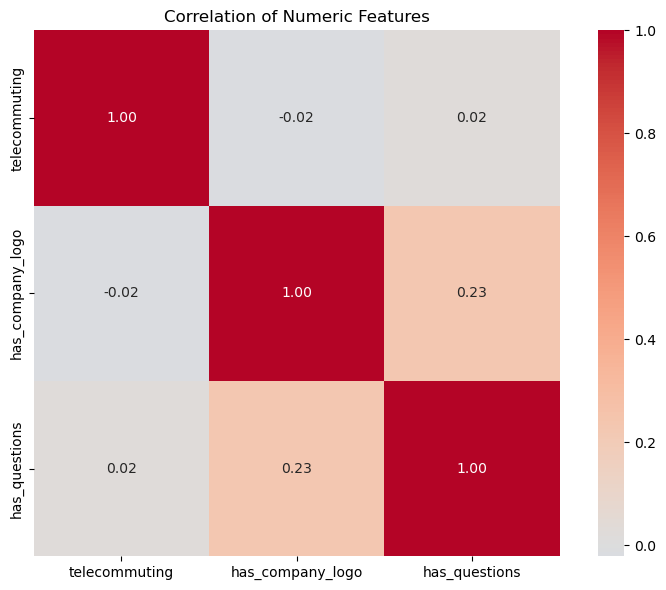

In [17]:
# correlation in numeric
job_numeric= jobs[numeric]
corr = job_numeric.corr()
plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",     
    center=0,            
    square=True
)
plt.title("Correlation of Numeric Features")
plt.tight_layout()
plt.show()

In [18]:
# Sanity checks
print(f"Checking for extreme values:\n\n {jobs[numeric].quantile([0,.01,.99,1])}")
print(f"Checking for feature domin  ance: \n\n {jobs[numeric].std().sort_values(ascending=False)}\n\n")


Checking for extreme values:

       telecommuting  has_company_logo  has_questions
0.00            0.0               0.0            0.0
0.01            0.0               0.0            0.0
0.99            1.0               1.0            1.0
1.00            1.0               1.0            1.0
Checking for feature domin  ance: 

 has_questions       0.499950
has_company_logo    0.404343
telecommuting       0.202510
dtype: float64




# Categorical Anlaysis

Categorical variables vary substantially in both cardinality and completeness. Some fields, such as job titles and locations, exhibit extremely high cardinality, while others (e.g., employment type and experience level) remain well-structured.

Missing values are prevalent across multiple categorical columns and are treated as informative rather than removed, as absence of information may itself reflect posting quality or intent.

### Interpretation of Categorical Cross-Tabulations:

- The cross-tabulation heatmaps summarize structural relationships between key categorical variables using a mix of row-normalized proportions and raw counts.

- Employment type varies meaningfully by job function, with full-time roles spanning a broad range of functions and contract or temporary roles concentrating in fewer areas. Experience level and education requirements exhibit strong alignment, indicating internally consistent posting standards.

- Job functions display distinct industry profiles, particularly for technical roles, while administrative and support roles appear across a wider range of industries. In contrast, department labels closely mirror job functions, suggesting redundancy between these features.

- Employment structure differs across industries, with some sectors showing higher proportions of non-traditional arrangements. Geographic comparisons highlight the dominance of the U.S. labor market while preserving variation in industry and employment structure across other countries.

- Experience level strongly influences posting volume and employment type, with entry-level and mid-level roles dominating the dataset. Education requirements further differentiate industry expectations and contribute signal independent of experience.

- Fraudulent postings exhibit modest variation across employment types and industries, but fraud does not concentrate heavily within any single category. These comparisons are descriptive and used for post-hoc validation only.

Overall, these visualizations reveal coherent categorical structure, justify feature grouping and exclusion decisions, and inform downstream feature preparation without imposing modeling assumptions.



In [19]:
for col in categorical:
    missing_rate = jobs[col].isna().mean()
    print(f"\n=== {col.upper()} ===")
    print(f"Cardinality of {col}: {len(jobs[col].value_counts(dropna=False))}")
    print(f"Missingness of {col}: {missing_rate:.2%} missing\n")
    print("Values counts:")
    print("__________________")
    print(jobs[col].value_counts(dropna=False).head(15))
    


=== REQUIRED_EXPERIENCE ===
Cardinality of required_experience: 8
Missingness of required_experience: 39.56% missing

Values counts:
__________________
required_experience
NaN                 6962
Mid-Senior level    3768
Entry level         2637
Associate           2267
Not Applicable      1070
Director             383
Internship           372
Executive            140
Name: count, dtype: int64

=== EMPLOYMENT_TYPE ===
Cardinality of employment_type: 6
Missingness of employment_type: 19.48% missing

Values counts:
__________________
employment_type
Full-time    11423
NaN           3428
Contract      1514
Part-time      772
Temporary      237
Other          225
Name: count, dtype: int64

=== DEPARTMENT ===
Cardinality of department: 1338
Missingness of department: 64.37% missing

Values counts:
__________________
department
NaN                       11328
Sales                       541
Engineering                 483
Marketing                   397
Operations                  266
IT  

In [20]:
# Create country column from location
location_split = jobs['location'].str.split(',', expand=True)
jobs['country'] = location_split[0].str.strip().replace('', pd.NA)

#Create columns where only using the top 20 countries and top 25 industries
top_industries = jobs['industry'].value_counts().nlargest(25).index
jobs['industry_grouped'] = jobs['industry'].where(jobs['industry'].isin(top_industries),'Other').fillna('Missing')
top_countries = jobs['country'].value_counts().nlargest(20).index
jobs['country_grouped'] = jobs['country'].where( jobs['country'].isin(top_countries), 'Other').fillna('Missing')


# Look at percentages of the 
cgvc=jobs['country_grouped'].value_counts(normalize=True)
igvc=jobs['industry_grouped'].value_counts(normalize=True)

print(f"Percentages of Country Grouped (n={len(cgvc)-1})")
print(f'{cgvc.head(10)*100}\n\n')

print(f"Percentages of Industry Grouped (n={len(igvc)-1}) ")
print(igvc*100)

Percentages of Country Grouped (n=20)
country_grouped
US       59.435195
GB       13.233706
Other     6.665151
GR        5.329848
CA        2.556963
DE        2.170578
NZ        1.875107
IN        1.551225
AU        1.210296
PH        0.750043
Name: proportion, dtype: float64


Percentages of Industry Grouped (n=25) 
industry_grouped
Other                                  43.496790
Information Technology and Services     9.722143
Computer Software                       7.739076
Internet                                5.988977
Education Management                    4.653674
Marketing and Advertising               4.647991
Financial Services                      4.250241
Hospital & Health Care                  2.744474
Consumer Services                       1.977385
Telecommunications                      1.852378
Oil & Energy                            1.625092
Retail                                  1.267117
Real Estate                             0.943235
Accounting                 

The data looks good for country_grouped: the dataset is US-heavy and then trails off. 

It also looks good for industry_grouped: the job market represented here is industry-diverse, not dominated by a few sectors.


 Given an employment structure, what roles does it typically represent?


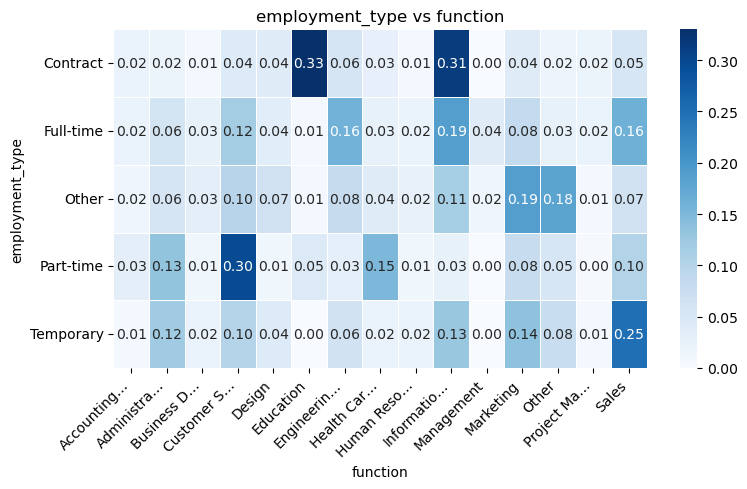


 For a given experience level, how do education requirements vary?


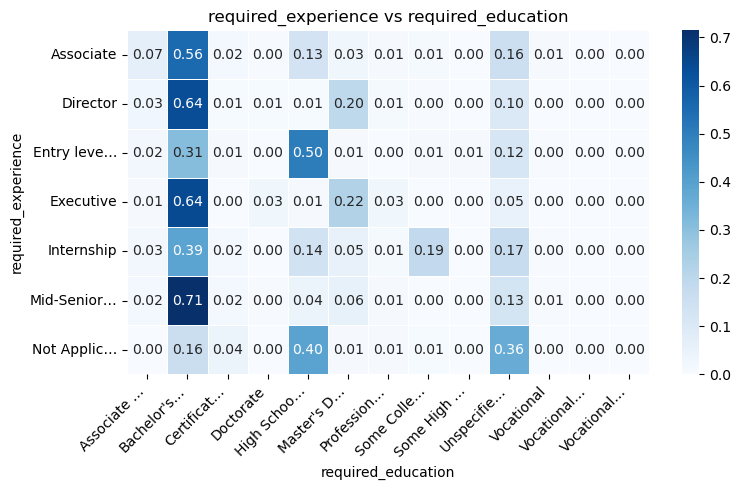


 Within each job function, which industries does it most often appear in?


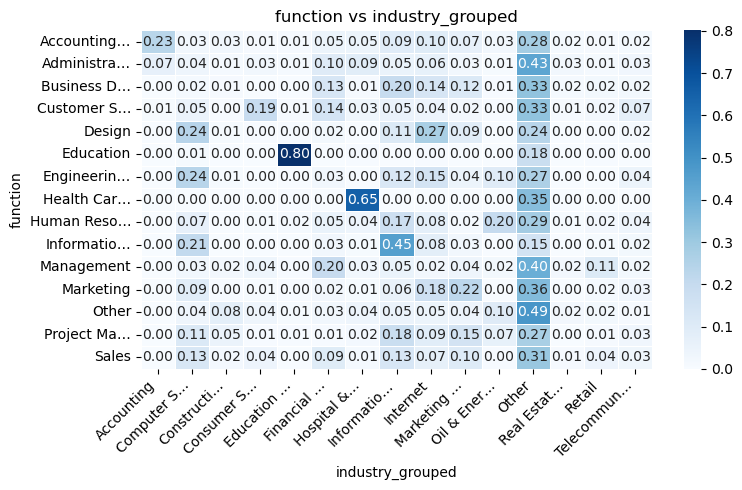


 Is department largely duplicating job function (redundancy check)?


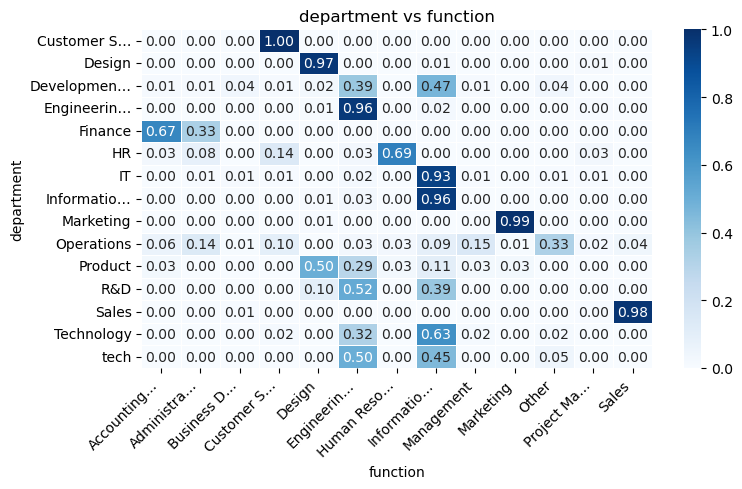


 Within each industry, how are jobs typically structured?


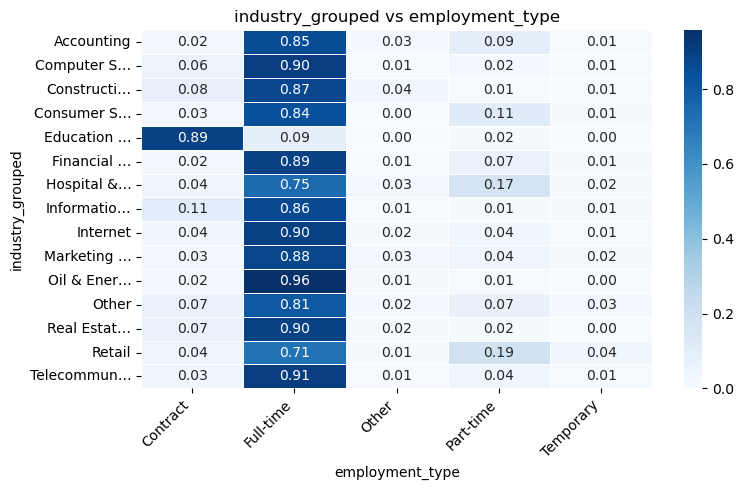


 Which employment types appear in each country and at what scale?


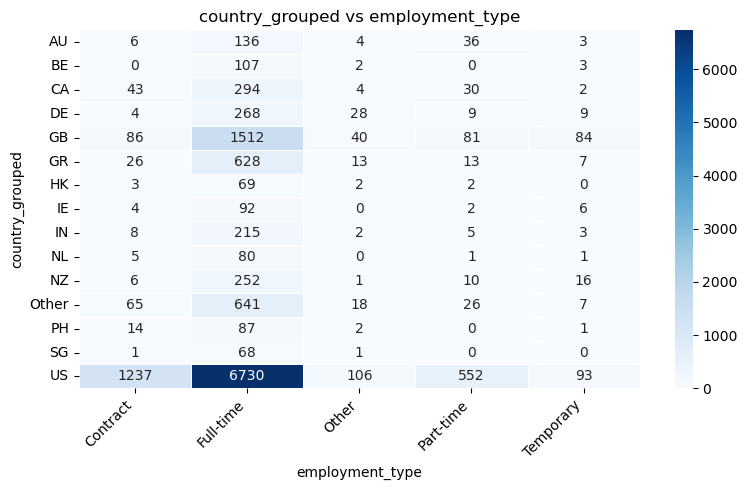


 Which industries are geographically concentrated across countries?


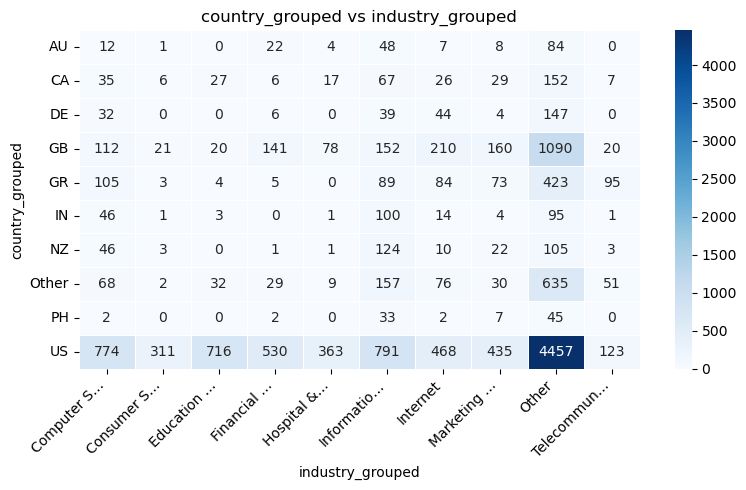


 Are certain experience levels associated with informal employment structures?


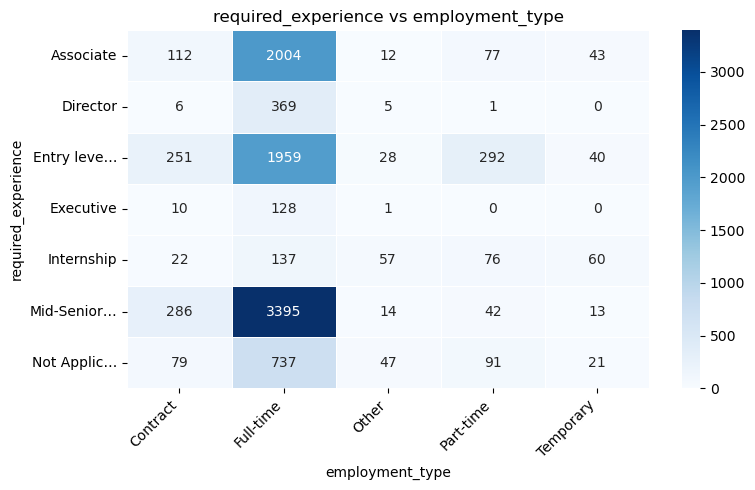


 Given an education requirement, which industries most commonly demand it?


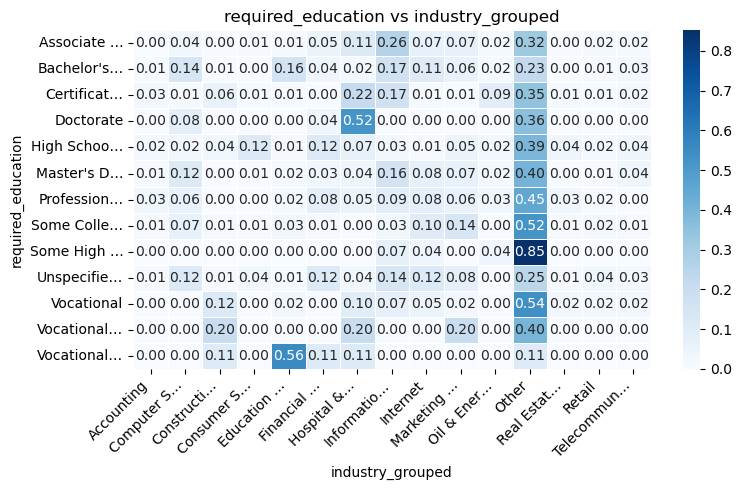


 Within each employment type, what fraction of jobs are fraudulent?


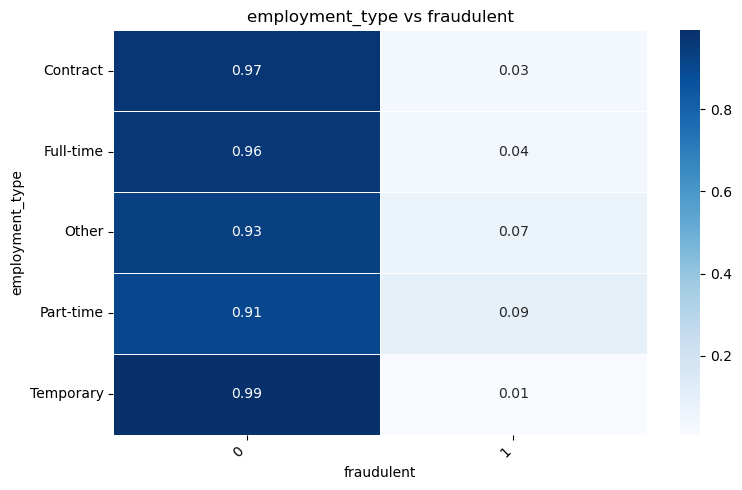


 Are certain industries disproportionately associated with fraud?


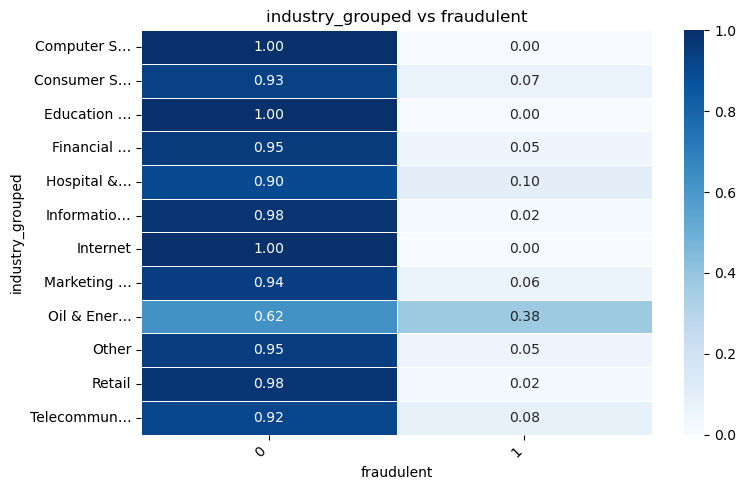

In [21]:
crosstab_pairs = [
    ('employment_type','function',{'normalize':'index'},
     'Given an employment structure, what roles does it typically represent?'),
     
    ('required_experience','required_education',{'normalize':'index'},
     'For a given experience level, how do education requirements vary?'),

    ('function','industry_grouped',{'normalize':'index'},
     'Within each job function, which industries does it most often appear in?'),

    ('department','function',{'normalize':'index'},
     'Is department largely duplicating job function (redundancy check)?'),

    ('industry_grouped','employment_type',{'normalize':'index'},
     'Within each industry, how are jobs typically structured?'),

    ('country_grouped','employment_type',{},
     'Which employment types appear in each country and at what scale?'),

    ('country_grouped','industry_grouped',{'max_categories':10},
     'Which industries are geographically concentrated across countries?'),

    ('required_experience','employment_type',{},
     'Are certain experience levels associated with informal employment structures?'),

    ('required_education','industry_grouped',{'normalize':'index'},
     'Given an education requirement, which industries most commonly demand it?'),

    ('employment_type','fraudulent',{'normalize':'index'},
     'Within each employment type, what fraction of jobs are fraudulent?'),

    ('industry_grouped','fraudulent',{'normalize':'index','max_categories':12},
     'Are certain industries disproportionately associated with fraud?')
]


for col_x,col_y,kwargs,why in crosstab_pairs:
    print(f"\n {why}")
    plot_crosstab_heatmap(jobs,col_x=col_x,col_y=col_y,**kwargs)



# Summary of Exploratory Findings

The exploratory analysis reveals meaningful structure across numeric, categorical, and text-derived features. Fraudulent postings differ systematically from legitimate ones in posting verbosity, lexical diversity, and categorical composition.

Feature grouping, explicit handling of missing values, and lightweight text-derived metrics collectively reduce noise while preserving signal. These findings inform feature preparation for subsequent unsupervised learning without prematurely constraining model design.


Based on the exploratory analysis, the following features are retained for downstream modeling due to their structural relevance, interpretability, and manageable dimensionality.

**Numeric and Binary Features**
- `telecommuting`: Captures remote work structure.
- `has_company_logo`: Proxy for posting legitimacy and effort.
- `has_questions`: Indicates applicant interaction requirements.
- `description_len`: Measures posting verbosity.
- `requirements_len`: Measures specificity of job requirements.
- `company_profile_len`: Measures organizational detail provided.

**Text-Derived Descriptive Features**
- `description_vocab`: Approximates lexical richness and repetition within job descriptions.

**Categorical Features**
- `employment_type`: Encodes job structure and contractual differences.
- `function`: High-level role classification with moderate cardinality.
- `required_experience`: Represents seniority expectations.
- `required_education`: Captures formal qualification requirements.
- `industry_grouped`: Retains industry signal while reducing sparsity.
- `country_grouped`: Encodes geographic context without excessive granularity.

**Excluded or Transformed Features**
- `department`: Excluded due to strong redundancy with `function`.
- `location`: Excluded due to extremely high cardinality and inconsistent formatting; geographic signal is preserved via `country_grouped`.
- `salary_range`: Excluded due to high missingness, inconsistent formatting, and limited interpretability without extensive parsing.
- `requirements_vocab`: Not retained due to high correlation with `requirements_len`, frequent templating, and substantial missingness across postings.
- `company_profile_vocab`: Not retained due to limited variability, boilerplate language, and redundancy with existing length-based features.
- Raw `industry` and `country`: Replaced by grouped versions to control cardinality.
- Raw text fields (`description`, `requirements`, `company_profile`): Retained for later text vectorization rather than direct numeric inclusion.
